In [1]:
import pandas as pd
import sqlite3
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

DATABASE_PATH = "./database/modules.db"
TOPICS_TABLE_NAME = "NERD_MODULES_NEW"
MODULES_TABLE_NAME = "SCORED_MODULES_NEW"
MODULE_COLUMN = "NAME"
KEYWORD_COLUMN = "TOPIC"

def getModuleTopics():
    
    db = sqlite3.connect(DATABASE_PATH)
    module_topics = pd.read_sql_query(f"SELECT * FROM {TOPICS_TABLE_NAME}", db)
    db.close()
    
    return module_topics

def getModules():
    
    db = sqlite3.connect(DATABASE_PATH)
    modules = pd.read_sql_query(f"SELECT * FROM {MODULES_TABLE_NAME}", db)
    db.close()
    
    return modules
    
# Method to prepare keywords
def prep_keywords(min_appearances, max_appearances_per_module = 7):
    module_topics = getModuleTopics()
    
    topic_appearances_per_module = module_topics.groupby([MODULE_COLUMN, KEYWORD_COLUMN]).size().reset_index(name="count")
    topic_appearances_per_module["count"] = topic_appearances_per_module["count"].clip(upper=max_appearances_per_module)
    
    unique_topics_count = topic_appearances_per_module.groupby(KEYWORD_COLUMN)["count"].sum().reset_index(name="count")
    unique_filtered_topics = unique_topics_count[unique_topics_count["count"] >= min_appearances].reset_index()
    
    return unique_filtered_topics[KEYWORD_COLUMN], unique_filtered_topics["count"]

# Method to embed keywords
def embed_keywords(keywords, model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(keywords, convert_to_tensor=True).cpu().numpy()
    return embeddings

def plot_silhouette_scores(Z, keyword_embeddings, t_values=None):
    
    if t_values is None:
        t_values = np.arange(len(keyword_embeddings)-1, 1, -len(keyword_embeddings)*0.1)
        
    silhouette_scores = []
    
    for t in t_values:
        clusters = fcluster(Z, t=t, criterion='maxclust')
        score = silhouette_score(keyword_embeddings, clusters) / t
        silhouette_scores.append(score)
    
    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different t Values')
    plt.xlabel('t value')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()
    
    return t_values, silhouette_scores

# Method to find the parent keyword for a single cluster
def cluster_parent(cluster_keywords, cluster_appearances, cluster_embeddings, dist_weight=0.9):
    mean_embedding = np.mean(cluster_embeddings, axis=0)
    distances = cdist([mean_embedding], cluster_embeddings, 'euclidean').flatten()
    
    epsilon=1e-10 # to prevent devision by zero
    
    max_count = max(cluster_appearances) + epsilon
    max_dist = distances.max() + epsilon
    
    norm_distances = distances /  max_dist
    norm_counts = 1 - (np.array(cluster_appearances) / max_count)
    
    scores = dist_weight * norm_distances + (1 - dist_weight) * norm_counts
    best_idx = np.argmin(scores)
    
    return cluster_keywords[best_idx]

# Method to find the parent keywords for all clusters
def cluster_parents(keywords, keyword_appearances, keyword_embeddings, keyword_cluster_mapping, dist_weight=0.7):
    cluster_parent_mapping = {}
    clusters = np.unique(keyword_cluster_mapping)
    
    silhouette_scores = silhouette_samples(keyword_embeddings, keyword_cluster_mapping)
    
    for cluster in clusters:
        cluster_indices = np.where(keyword_cluster_mapping == cluster)[0]
        cluster_embeddings = keyword_embeddings[cluster_indices]
        cluster_keywords = [keywords[i] for i in cluster_indices]
        cluster_appearances = [keyword_appearances[i] for i in cluster_indices]
        
        silhouette_scores_cluster = silhouette_scores[cluster_indices]
        #best_sil_idx = np.argmax(silhouette_scores_cluster)
        
        cluster_parent_mapping[cluster] = cluster_parent(cluster_keywords, cluster_appearances, cluster_embeddings, dist_weight)
    
    return cluster_parent_mapping, silhouette_scores

def cluster_keywords(keywords, keyword_appearances, keyword_embeddings, distance_threshold=8.5, Z = None, dist_weight=0.7):
    
    if Z is None:
        Z = linkage(keyword_embeddings, method='ward') 
    
    # calculate optimal silhoutte score
    # plot_silhouette_scores(Z, keyword_embeddings)
        
    keyword_cluster_mapping = fcluster(Z, t=distance_threshold, criterion='distance')
    cluster_parent_mapping, silhouette_scores = cluster_parents(keywords, keyword_appearances, keyword_embeddings, keyword_cluster_mapping, dist_weight)
    
    parents = map(lambda x: cluster_parent_mapping[x], keyword_cluster_mapping)
    return list(parents), silhouette_scores

def keyword_hierarchy_unbiased(keywords, keyword_embeddings, keyword_appearances, height, distance_threshold=8.5, distance_increment=0.5):  
    
    current_keywords = keywords
    current_keyword_embeddings = keyword_embeddings
    current_keyword_appearances = keyword_appearances
    hierarchy_df = pd.DataFrame({f'level 0': keywords})

    for level in range(1, height, 1):
        parents = cluster_keywords(current_keywords, current_keyword_appearances, current_keyword_embeddings, distance_threshold=level*distance_increment+distance_threshold)
        keyword_parent_map = dict(zip(current_keywords, parents))
        
        # Add parent clusters to the DataFrame
        hierarchy_df[f'level {level}'] = hierarchy_df[f'level {level - 1}'].map(keyword_parent_map)
        
        # Prepare for the next level
        parent_set = set(parents)
        current_keywords = list(parent_set)
        
        # Avoid using list comprehension directly in np.array
        current_keyword_embeddings = np.array([keyword_embeddings[keywords.index(kw)] for kw in current_keywords])
        current_keyword_appearances = [keyword_appearances[keywords.index(kw)] for kw in current_keywords]
        
        print(len(current_keyword_embeddings))

    return hierarchy_df

def keyword_hierachy(keywords, keyword_embeddings, keyword_appearances, cutting_distances, Z = None, dist_weight=0.7):
    
    hierarchy_df = pd.DataFrame({f'level 0': keywords})
    hierarchy_df["appearances"] = keyword_appearances
    
    if Z is None:
        Z = linkage(keyword_embeddings, method='ward') 
        
    level = 0
    
    print(f"keyword count: {len(keywords)}")
    
    for cutting_distance in cutting_distances:
        level = level + 1
        
        parents, silhouette_scores = cluster_keywords(keywords, keyword_appearances, keyword_embeddings, distance_threshold=cutting_distance, Z=Z, dist_weight=dist_weight)
        
        # average cluster size 
        print(f"cluster count: {len(set(parents))}")
        
        hierarchy_df[f'level {level}'] = parents
        hierarchy_df[f'level {level} score'] = silhouette_scores
        
    return hierarchy_df


/Users/bene/PycharmProjects/Topic Clustering/.venv/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
from DataPrep import prep_keywords
keywords, keyword_appearances = prep_keywords(min_appearances=500)
len(keywords)
print("Hello world")

OperationalError: unable to open database file

In [9]:
keyword_embeddings = embed_keywords(keywords)

NameError: name 'keywords' is not defined

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(keyword_embeddings)

NameError: name 'keyword_embeddings' is not defined

In [11]:
tsne_df = pd.DataFrame(tsne_result)
tsne_df["keyword"] = keywords
tsne_df["appearances"] = keyword_appearances
tsne_df.rename(columns={0: "x", 1: "y"}, inplace=True)
tsne_df.to_csv("database/keywords_greater3_tsne_result_.csv", index=False)
tsne_df

NameError: name 'tsne_result' is not defined

In [43]:
Z = linkage(keyword_embeddings, method='ward')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

keywords, keyword_appearances = prep_keywords(min_appearances=500)
keyword_embeddings = embed_keywords(keywords)
Z = linkage(keyword_embeddings, method='ward')

sns.set_palette("tab20")
plt.figure(figsize=(8, 8))
dendrogram(Z, orientation='right', labels=list(keywords), color_threshold=1.5)
plt.xlabel("Linkage distance (ward)")
plt.ylabel("Topics with over 500 appearances")
plt.axvline(x=1.35, color='blue', linestyle='--', label='Threshold at 1.35')

# Display the plot
plt.show()

NameError: name 'dendrogram' is not defined

<Figure size 800x800 with 0 Axes>

In [406]:
#df = keyword_hierarchy_unbiased(list(keywords), keyword_embeddings, keyword_appearances, height=6)
df = keyword_hierachy(keywords, keyword_embeddings, keyword_appearances, cutting_distances=[1.2, 2, 4, 7.5], Z=Z, dist_weight=0.7)

keyword count: 24721
cluster count: 5891
cluster count: 1629
cluster count: 279
cluster count: 50


In [407]:
# I want to get a seperate dataset for each layer
df["x"] = tsne_df["x"]
df["y"] = tsne_df["y"]
df.to_csv("database/greater3_5levels.csv", index=False)

In [411]:
def export1level(level):
    grouped = df.groupby(level, as_index=False).agg({
        'appearances': 'sum'
    })
    result = pd.merge(grouped, df[df['level 0'] == df[level]][[level, 'x', 'y']], on=level)
    result.to_csv(f"database/greater3_clusters_{level}.csv", index=False)

export1level("level 0")

<Axes: >

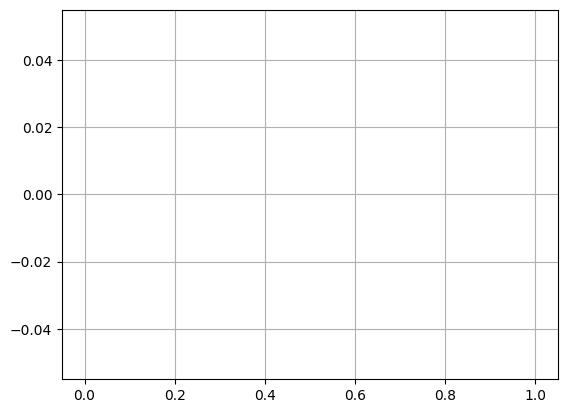

In [340]:
df[df["appearances"] < 10]["appearances"].hist(bins=100)

In [312]:
testset1 = ["tree", "flower", "grass", "plant", "milk", "butter", "cheese", "apple", "banana", "fruit", "dairy product", "groceries"]
testset2 = ["tree", "flower", "grass", "plant", "milk", "butter", "cheese", "apple", "banana", "fruit", "dairy product", "groceries", "love", "emotion", "happy", "angry", "pizza", "burger", "ice cream", "food"]


testset_keywords = testset1
testset_keyword_appearances = np.full((len(testset_keywords), 1), 10)
testset_keyword_embeddings = embed_keywords(testset_keywords)
Z_testset = linkage(testset_keyword_embeddings, method='ward') 

In [313]:
dendogram

NameError: name 'dendogram' is not defined

In [302]:
df_testset = keyword_hierachy(testset_keywords, testset_keyword_embeddings, testset_keyword_appearances, cutting_distances=[12], Z=Z_testset, dist_weight=0.7)
df_testset["level 1 score"].mean()

keyword count: 20
cluster count: 5


np.float32(0.13319457)

In [303]:
df_testset.groupby("level 1")["level 1 score"].mean()

level 1
dairy product    0.174538
emotion          0.181617
food             0.046553
fruit            0.112505
plant            0.167248
Name: level 1 score, dtype: float32

In [304]:
print(df["level 1 score"].mean(),
df["level 2 score"].mean(),
df["level 3 score"].mean())

0.13874722 0.052599773 0.015022528


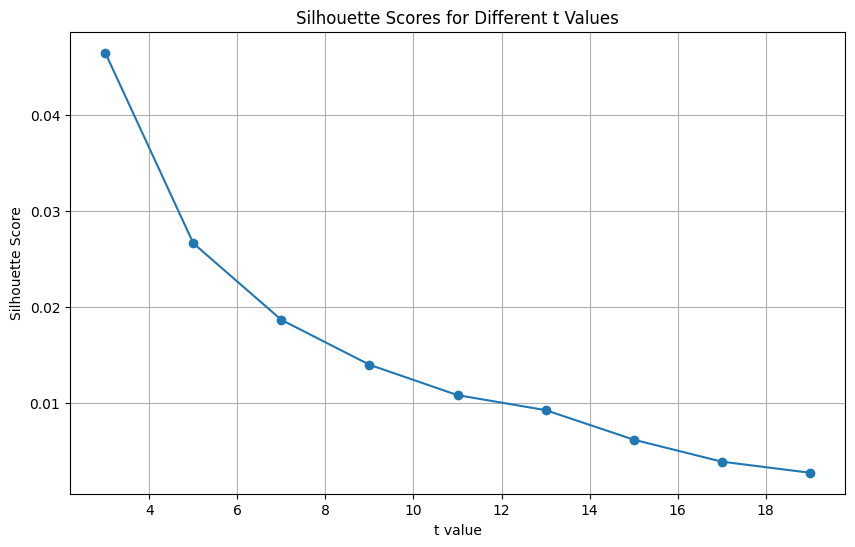

(array([19., 17., 15., 13., 11.,  9.,  7.,  5.,  3.]),
 [np.float64(0.0027178569059622916),
  np.float64(0.0038725948509048015),
  np.float64(0.006165861586729686),
  np.float64(0.009244110148686629),
  np.float64(0.010806244205344807),
  np.float64(0.013977780938148499),
  np.float64(0.018655195832252502),
  np.float64(0.02663891315460205),
  np.float64(0.04650999108950297)])

In [311]:
plot_silhouette_scores(Z_testset, testset_keyword_embeddings)

In [184]:
import plotly.express as px

px.treemap(df, path=["level 3", "level 2", "level 1"], template="simple_white", title="Hierarchy Explorer")

In [163]:
df[df["level 1"] == "Project management"].sort_values(by="level 1 score", ascending=False)[["level 0","level 1", "level 1 score"]]

,level 0,level 1,level 1 score
6680,Project management software,Project management,0.332927
6671,Project Management Professional,Project management,0.330377
6679,Project management,Project management,0.302297
5991,Organizational project management,Project management,0.295116
1407,Comparison of project management software,Project management,0.266715
6681,Project manager,Project management,0.257519
7739,Software project management,Project management,0.203760
5035,Master of Science in Project Management,Project management,0.193622
5324,Milestone (project management),Project management,0.164677
7372,Schedule (project management),Project management,0.134425


In [148]:
##compare labeling techniques: centroid vs silhoutte

# Group by 'level 1' and get the row with the maximum 'level 1 score'
max_scores_df = df.loc[df.groupby("level 2")["level 2 score"].idxmax()]

# Filter where 'level 1' differs from 'level 0'
filtered_df = max_scores_df[max_scores_df["level 2"] != max_scores_df["level 0"]]
filtered_df

,level 0,appearances,level 1,level 1 score,level 2,level 2 score
63,Aircraft flight mechanics,31,Aircraft flight dynamics,0.108926,Aerospace engineering,0.218564
2567,Sanskrit studies,33,Sanskrit,0.405090,Akkadian language,0.104470
547,Consistency,34,Consistency,0.131413,Analysis,0.009107
290,Building,257,Building,0.136683,Architecture,0.143175
154,Art,78,Art,0.024960,Art history,0.235090
...,...,...,...,...,...,...
3169,Writing,209,Writing,0.277961,Thesis,0.114240
2782,Sport industry,53,Sporterising,0.148704,United Nations Office on Sport for Development...,0.159431
3081,Urbanization,33,Urban area,0.083926,Urban planning,0.296577
2301,Pricing,69,Asset pricing,-0.148009,Valuation (finance),0.126368


In [60]:
allTopics = getModuleTopics()

In [64]:
topic_appearances_per_module = allTopics.groupby([MODULE_COLUMN, KEYWORD_COLUMN]).size().reset_index(name="count")
topic_appearances_per_module["count"] = topic_appearances_per_module["count"].clip(upper=7)

unique_topics_count = topic_appearances_per_module.groupby(KEYWORD_COLUMN)["count"].sum().reset_index(name="count")
unique_topics_count

,TOPIC,count
0,"""Hello, World!"" program",1
1,"""I AM"" Activity",4
2,'Aoa,1
3,'Ilm al-huruf,2
4,'The All-Species Living Tree' Project,3
...,...,...
56224,Ḍād,4
56225,Ḱérberos,3
56226,Ḷḷumés,1
56227,Ṭa (Indic),1


In [63]:
allTopicsWithParents = pd.merge(allTopics, df, how='left', left_on="TOPIC", right_on="level 0")
allTopicsWithParents = pd.merge(allTopicsWithParents, unique_topics_count, how='left', on="TOPIC")
allTopicsWithParents = allTopicsWithParents.dropna()
allTopicsWithParents["rarity score"] = 1 / allTopicsWithParents["count"]
allTopicsWithParents

,TOPIC,INDEX,NAME,SPAN,TOPIC_ID,TOPIC_SCORE,level 0,level 1,level 2,level 3,level 4,level 5,count,rarity score
0,"""Hello, World!"" program",53970,Praktikum Entwurf und Realisierung eines Spann...,Hello World,13834,0.958529,"""Hello, World!"" program",Cinderella (software),Python (programming language),MATLAB,Finite element method,Data collection,1,1.000000
1,"""I AM"" Activity",61998,Kompetenz in Gesundheitsförderung II (GS),movement,3564374,0.022469,"""I AM"" Activity","""I AM"" Activity",Meš,Tardive dyskinesia,Morphology (linguistics),Literature,4,0.250000
2,'Aoa,2346,TaxVertiefung - Besteuerung von Betriebsstätte...,AOA,21025324,0.034034,'Aoa,AoS and SoA,OSI model,Human factors and ergonomics,Morphology (linguistics),Literature,1,1.000000
3,'Ilm al-huruf,45166,Wissenschaftliches Schreiben II,Scientific Letter II,51782084,0.042980,'Ilm al-huruf,Bulugh al-Maram,Alkene,Human factors and ergonomics,Morphology (linguistics),Literature,2,0.500000
4,'The All-Species Living Tree' Project,55234,Waldstandorte,tree species,33821697,0.210506,'The All-Species Living Tree' Project,AVL tree,Decision tree,Decision tree,Ecology,Sustainability,3,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56223,Ω-consistent theory,45814,Erweiterungsmodul Ältere Sprachstufe I (Franz...,sound theory,4066001,0.105536,Ω-consistent theory,M-theory,Theory,Theory,Theory,Methodology,4,0.250000
56224,Ḍād,66593,"Chemie, Analytik und Technologie der Lebensmittel",DAD,3656690,0.023523,Ḍād,Ḍād,Developmental psychology,Developmental psychology,Development studies,Cultural studies,4,0.250000
56226,Ḷḷumés,56001,Theoretische Physik 4A (Statistische Mechanik ...,classic limes,22138459,0.030869,Ḷḷumés,Enumeration,Big data,Big data,Methodology,Methodology,1,1.000000
56227,Ṭa (Indic),59607,Perspektiven der Technikfolgenabschätzung,TA,50823222,0.151010,Ṭa (Indic),Ṭa (Indic),Tshe,Virology,Morphology (linguistics),Literature,1,1.000000


In [6]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

def prepare_wiki_link(topic):
    topic_encoded = topic.replace(" ", "_")
    return f"https://en.wikipedia.org/wiki/{topic_encoded}"

def highlight_spans(description, spans, topics):
    for span, topic in zip(spans, topics):
        wikiLink = prepare_wiki_link(topic)
        description = description.replace(f" {span}", f" <mark>{span}</mark>")
        
    print(description)
    return description

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='module-dropdown',
        options=[{'label': module, 'value': module} for module in allModules["NAME"]],
        placeholder="Select a module"
    ),
    html.Div(id='module-description', style={'margin': 50}),
    dcc.Slider(2, 5,
        step=None,
        marks={
            2: 'level 2',
            3: 'level 3',
            4: 'level 4',
            5: 'level 5'
        },
        value=2, id='level-slider'
    ),
    html.Div(
        dcc.Graph(id='sunburst-graph'),
        style={'display': 'flex', 'justifyContent': 'center', 'margin': 50}
    ),
    html.Div(
        dcc.Graph(id='histogram-graph'),
        style={'display': 'flex', 'justifyContent': 'center', 'margin': 50}
    )
], style={'textAlign': 'center', 'backgroundColor': 'white', 'margin': 50})

@app.callback(
    [Output('sunburst-graph', 'figure'),
     Output('module-description', 'children'),
     Output('histogram-graph', 'figure')],
    [Input('module-dropdown', 'value'), Input('level-slider', 'value')]
)
def update_graph_and_description(module_name, level_slider):
    if module_name:
        moduleTopics = allTopicsWithParents[allTopicsWithParents["NAME"] == module_name]
        fig = px.sunburst(moduleTopics, path=[f"level {level_slider}", 'level 0'], width=1000, height=1000, template="simple_white", title="Module Topics")
        
        description = allModules[allModules["NAME"] == module_name]["ENGLISH_DESCRIPTION"].values[0]
        
        spanWithTopics = moduleTopics.groupby('SPAN').first().reset_index()
        
        highlighted_description = highlight_spans(description, spanWithTopics["SPAN"], spanWithTopics["TOPIC"])
        
        clustersGrouped = moduleTopics.groupby(f"TOPIC").first().reset_index().sort_values("count", ascending=True)
        
        histogram_fig = px.histogram(clustersGrouped, x="count", y=f"TOPIC", template="simple_white", histfunc='avg', log_x=True, title="Global appearances per topic", width=800, height=800, labels={
            "count":"Global appearances", "TOPIC":"Topic"}, text_auto=True)
        
        return fig, html.Div(dcc.Markdown(highlighted_description, dangerously_allow_html=True)), histogram_fig
    return {}, ""

app.run(port=8080, jupyter_mode="tab")


ModuleNotFoundError: No module named 'dash'

In [18]:
import plotly.express as px 

allTopicsWithParents = pd.read_csv("allTopicsWithParents.csv")
allTopicsWithParents = allTopicsWithParents.dropna()

In [20]:
fig = px.treemap(allTopicsWithParents.head(), path=[px.Constant('All'), 'level 4', 'level 3', 'level 2', 'level 1', 'level 0'], height=800, template="simple_white")

In [49]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import dash_daq as daq

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Tabs([
        dcc.Tab(label='Hierarchy Explorer', children=[
            dcc.Input(
                id='topic-search',
                type='text',
                placeholder='Search for a topic',
                style={'margin': '10px'}
            ),
            dcc.Graph(id='tree-graph', style={'margin': 50}),
            daq.ToggleSwitch(
                id='toggle-switch',
                label='Show Details',
                style={'margin': 'auto'},
                value=False
            )
        ])
    ])
], style={'textAlign': 'center', 'backgroundColor': 'white', 'margin': 50})

@app.callback(
    Output('tree-graph', 'figure'),
    [Input('toggle-switch', 'value'),
     Input('topic-search', 'value')]
)
def update_tree_graph(show_details, search_query):
    tree_data = allTopicsWithParents.groupby("TOPIC").first().reset_index()
    
    if search_query and search_query != "":
        tree_data = allTopicsWithParents.copy()
        tree_data = tree_data[tree_data.apply(lambda row: search_query.lower() in str(row).lower(), axis=1)]
    
    path = ["level 4", "level 3", "level 2", "level 1", "level 0"]
    
    if not show_details:
        path = ["level 4", "level 3", "level 2"]
    
    fig = px.treemap(tree_data, path=path, template="simple_white", title="Hierarchy Explorer")
    return fig

app.run_server(debug=True, port=8083, jupyter_mode="tab")    


Dash app running on http://127.0.0.1:8083/


<IPython.core.display.Javascript object>

In [50]:
getModuleTopics().to_csv("module topics")

,TOPIC,Unnamed: 0,INDEX,NAME,SPAN,TOPIC_ID,TOPIC_SCORE,level 0,level 1,level 2,level 3,level 4,count
5804,Bridge,85,61253,Massivbau,Massive Bridge Construction,3397,0.030521,Bridge,Bridge,Bridge,Tunnel construction,Boundary value problem,53.0


,TOPIC,Unnamed: 0,INDEX,NAME,SPAN,TOPIC_ID,TOPIC_SCORE,level 0,level 1,level 2,level 3,level 4,count
0,"""Hello, World!"" program",235682,53970,Praktikum Entwurf und Realisierung eines Spann...,Hello World,13834,0.958529,"""Hello, World!"" program",Cinderella (software),Python (programming language),MATLAB,Finite element method,1.0
1,"""I AM"" Activity",131549,61998,Kompetenz in Gesundheitsförderung II (GS),movement,3564374,0.022469,"""I AM"" Activity","""I AM"" Activity",Meš,Meš,Historiography,4.0
2,'Aoa,488519,2346,TaxVertiefung - Besteuerung von Betriebsstätte...,AOA,21025324,0.034034,'Aoa,AoS and SoA,OSI model,UML tool,Human factors and ergonomics,1.0
3,'Ilm al-huruf,515033,45166,Wissenschaftliches Schreiben II,Scientific Letter II,51782084,0.042980,'Ilm al-huruf,Bulugh al-Maram,Alkene,"Esfand, Sistan and Baluchestan",Human factors and ergonomics,2.0
4,'The All-Species Living Tree' Project,210435,55234,Waldstandorte,tree species,33821697,0.210506,'The All-Species Living Tree' Project,AVL tree,Decision tree,Decision tree,Forest management,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ASIC programming language,460934,65048,Entwicklung von Integrierten Schaltungen,ASIC development,1459799,0.913683,ASIC programming language,ASIC programming language,Asepsis,Asepsis,Historiography,2.0
496,ASIMO,10841,57041,"Smarte Mobilität - verstehen, modellieren, ges...",Designing mobility T7,500894,0.541745,ASIMO,ASIMO,Asepsis,Asepsis,Historiography,7.0
497,ASP.NET,374677,60239,Nachrichtentechnik 2,ASP,651996,0.981152,ASP.NET,Netty (software),Net (polyhedron),Capacitive sensing,Final good,1.0
498,ASQ,409791,31292,Additional Qualification outside Natural Scien...,ASQ,2073962,0.093702,ASQ,ASQ,Asepsis,Asepsis,Historiography,6.0
